### Introduction

In this course, we'll be building a neural network model which classifies handwritten digits. We'll be doing this with the University of California, Irvine's dataset of hand-written digits. You can read about the dataset [here](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). The scikit-learn library actually already contains the dataset, so we can load the dataset by importing the load_digits() function and running it.

In [128]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits_data = load_digits()
data = pd.DataFrame(digits_data["data"])
labels = pd.Series(digits_data["target"])
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0


### How Images Are Represented in DataFrames

We can see above that each row of the dataset has 64 values. Each of these rows constitutes a single image. But how do the values in these columns relate to an image?

A digital image is a 2-dimensional array of pixels. That is, every image is made up of a grid of A x B pixels in the x and y direction. This AxB grid of pixels is what we normally call the resolution of the picture.

When we view the image, if we were to look at the individual pixels, we'd see that each of the pixels was a specific color. A specific pixel could be red, green, black, white, grey, and so on, but only ever one color, never a mix of two or more.

The fact that pixels are only ever one specific color, combined with the resolution of the picture, is why certain digital images look crisper than others. If there are a small number of pixels to represent the image, then there  is a lower limit to the number of different colors that image can be composed of, which means that finer details of certain images, like curves, or gradual color changes, are lost, because they can only be approximated by multiple pixels.

For example, think of a digital clock which represents the numbers 0 through 9. Some of the numbers, like 1, are linear, and so are well represented by the clock. Other numbers, however, like 3, are curved, and the clock is not as able to display the number 3 because of this. We can still recognize the number, of course, but it doesn't look the same as a 3 would if we were to write it ourselves. This limitation of the digital clock is the same limitation for digital photos. The digital clock, having only 7 lines which can be switched on or off, is like a picture with 7 pixels.

Now, the specific color of a pixel can be represented by a number. The number 1 might represent black, 2 a dark grey, 3 a light grey, and 4 white. If our image is a collection of 8x8 pixels, totalling 64 pixels, then we could represent our image with a set of 64 numbers, with each of those numbers representing the color of the pixel at a specified position.

This is what we see in our dataframe. We have 64 columns, which means 64 values for each image. Each row of our dataframe, therefore, represents an 8x8 image. The values in each of the columns indicate the color of the pixel in the given position of the image.

Now that we understand how this representation works, we need to find a way of converting the stored values for each pixel into an actual image. We can do this by reshaping the row, which is currently a pandas series with 64 columns, into a 2D array with dimensions (8, 8). We can use the numpy.reshape() function to do this. Finally, to make it into an image, we'll plot the values contained in the reshaped array on a graph. Let's do this wiht a few different rows from our dataset.

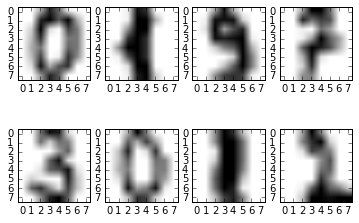

In [25]:
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

### Selecting an Algorithm: K-Nearest Neighbors

We've got some nice-ish looking numbers above so that we can better understand how our dataset represents images, but now we need to pick an algorithm which can predict what number an image represents.

Models like linear regression and logistic regression will be poorly suited to this task, as they assume some amount of linearity between the features (in this case, pixel values) and the target/labels (in this case, the number itself). Clearly, however, there is no such linearity with numbers.

One option that may be good is a k-nearest neighbors algorithm. This algorithm does not produce a mathematical model for prediction, but instead, for a given row, compares the values in the columns for that row with the values in the columns for the rows in a training set, selects the k most similar rows, and then makes a prediction based on the labels of those rows.

Let's try out a knn algorithm and see how it goes. We'll need to split our data into train and test portions, which we'll do using k-fold cross validation.

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def knn_train_test(nneighbors, train_features, train_target, test_features, test_target):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_target)
    predictions = knn.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_target
    train_test_df['predicted_label'] = predictions
    accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)  
    return(accuracy)

def cross_validate(k):
    accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.iloc[train_index], data.iloc[test_index]
        train_target, test_target = labels.iloc[train_index], labels.iloc[test_index]
        accuracy = knn_train_test(k, train_features, train_target, test_features, test_target)
        accuracies.append(accuracy)
    mean_acc = np.mean(accuracies)
    return(mean_acc)

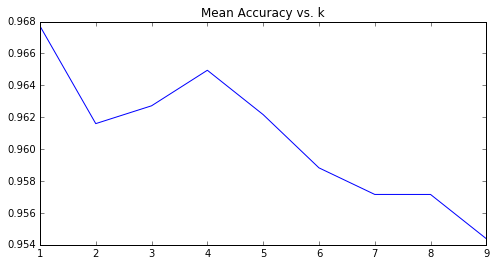

In [152]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracy = cross_validate(k)
    k_overall_accuracies.append(k_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

### K-Fold KNN Analysis

All of the models seem highly accurate - predicting the correct label over 95% of the time, with the best model predicting the correct label almost 97% of the time.

### Selecting an Algorithm: Neural Networks

Now let's try using a neural network model to predict the number from the pixels. Unlike linear regression and logistic regression models, neural networks are able to handle non-linear relationships in the data they're predicting.

Neural networks are similar to linear regression models in that the simplest of neural networks is just a linear regression model. A basic neural network will take features as an input, find the appropriate weightings to assign to each of them, and then take the sum of these features multiplied by their weightings to predict the output.

A multilayer neural network, however, is more complex. It still takes the same features as an input, but this time, rather than just assigning weightings and predicting the output, it will take the inputs, multiply them by the appropriate weightings, and then transform them again, meaning that relationships between the inputs can be taken into account. The more layers there are in the network, the more complexity can be introduced regarding the relationships between the input features and the features and the output.

We'll begin with a two layer neural network before moving on to more complex neural networks.

In [167]:
from sklearn.neural_network import MLPClassifier

def nn_train_test(neuron_tuple, train_features, train_target, test_features, test_target):
    mlp = MLPClassifier(hidden_layer_sizes = neuron_tuple, max_iter = 250)
    mlp.fit(train_features, train_target)
    predictions = mlp.predict(test_features)
    train_test_nn_df = pd.DataFrame()
    train_test_nn_df['correct_label'] = test_target
    train_test_nn_df['predicted_label'] = predictions
    accuracy = sum(train_test_nn_df["predicted_label"] == train_test_nn_df["correct_label"])/len(train_test_nn_df)  
    return(accuracy)

def cross_validate_nn(neuron_tuple):
    accuracies = []
    kf = KFold(n_splits = 4, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.iloc[train_index], data.iloc[test_index]
        train_target, test_target = labels.iloc[train_index], labels.iloc[test_index]
        accuracy = nn_train_test(neuron_tuple, train_features, train_target, test_features, test_target)
        accuracies.append(accuracy)
    mean_acc = np.mean(accuracies)
    return(mean_acc)

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


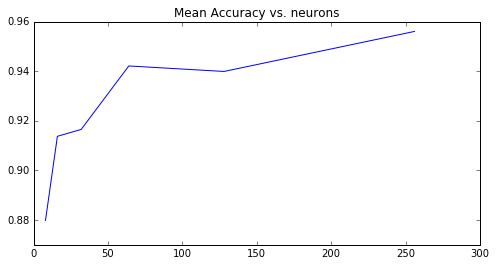

In [166]:
single_layer_neurons = [(8,), (16,), (32,), (64,), (128,), (256,)]

single_layer_accs = []

for neuron in single_layer_neurons:
    mean_acc = cross_validate_nn(neuron)
    single_layer_accs.append(mean_acc)
    
neurons = [i[0] for i in single_layer_neurons]
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. neurons")
plt.plot(neurons, single_layer_accs)

While neural network models with few neurons in the hidden layer faired worse than the knn algorithm we used above, as we added more neurons they began to perform far more similarly. However, the knn algorithms still performed slightly better, so let's see if we can train a neural networks model with additional hidden layers to be better than the knn algorithm.

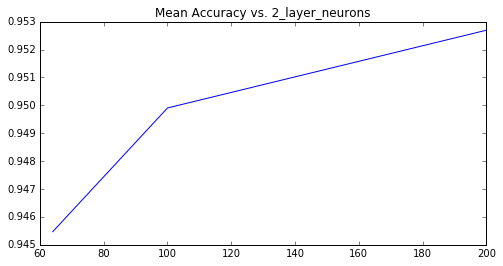

In [168]:
double_layer_neurons = [(64, 64), (100, 100), (200, 200)]

double_layer_accs = []

for neuron in double_layer_neurons:
    mean_acc = cross_validate_nn(neuron)
    double_layer_accs.append(mean_acc)
    
neurons = [i[0] for i in double_layer_neurons]
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. 2_layer_neurons")
plt.plot(neurons, double_layer_accs)

Finally, let's test out our model with 3 layers. The more layers we add, the more our model begins to overfit to the dataset it's trained on. To counter this, we can increase the number of folds we use in our k-fold cross validation function. We'll increase it to 8 and try out a few different three-layer neural networks

In [169]:
def cross_validate_nn(neuron_tuple):
    accuracies = []
    kf = KFold(n_splits = 8, random_state = 2)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.iloc[train_index], data.iloc[test_index]
        train_target, test_target = labels.iloc[train_index], labels.iloc[test_index]
        accuracy = nn_train_test(neuron_tuple, train_features, train_target, test_features, test_target)
        accuracies.append(accuracy)
    mean_acc = np.mean(accuracies)
    return(mean_acc)

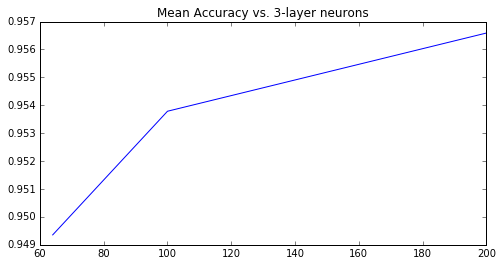

In [170]:
triple_layer_neurons = [(64, 64, 64), (100, 100, 100), (200, 200, 200)]

triple_layer_accs = []

for neuron in triple_layer_neurons:
    mean_acc = cross_validate_nn(neuron)
    triple_layer_accs.append(mean_acc)
    
neurons = [i[0] for i in triple_layer_neurons]
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. 3-layer neurons")
plt.plot(neurons, triple_layer_accs)

### Conclusion

Interestingly, there is actually very little improvement going from 1 hidden layer in a neural network to 3, although it should be noted that we reduced the number of neurons in each layer from 250 in the 1 hidden layer network to 200 in the 2 and 3 hidden layer networks. It's possible if we'd continued modelling up to 250 neurons per layer we'd have seen even more of an improvement in the 3-layer model.

Worth noting as well is that our final neural network model with 200 neurons in three layers was just on par with the knn algorithm we ran initially. The knn algorithm was also significantly quicker to run for a dataset of our size. So, why choose a neural network model over the knn algorithm?

Training each of the neural network models takes a long time, but once trained they should make predictions more readily (as we're essentially just applying a highly calculated non-linear equation to our feature inputs). Conversely, knn doesn't build a model, and so it will always have to map every point in the dataset and compare each of them to the point whose value we're trying to predict.

Additionally, we've stopped trying to improve our neural network after a relatively small number of changes. We can see that it has continued to improve with each tweak, and if we continued we may well end up with a model with greater accuracy than the knn algorithm exhibited. As for the knn algorithm, it's not clear how we'd improve it in this case, and so the best value we observed in our initial test is likely the ceiling for the algorithm's predictive accuracy.